# UnrealCV Commands Demo

In [1]:
from unrealcv.automation import UE4Binary
from unrealcv.util import read_png, read_npy
from unrealcv import client

In [3]:
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline

In [4]:
import os
binary_path = './MacNoEditor/RealisticRendering.app/Contents/MacOS/RealisticRendering'
if os.path.isfile(binary_path):
    # Use .exe file for windows.
    binary = UE4Binary(binary_path) # UE4Binary can support exe, linux and mac binary
    binary.start()
else:
    print("Can not find binary file %s \nWorking directory is %s" % (binary_path, os.path.abspath('.')))


In [5]:
client.connect()
print(client.request('vget /unrealcv/version'))
print(client.request('vget /unrealcv/status'))

INFO:__init__:192:Got connection confirm: b'connected to RealisticRendering'


0.3.10
Is Listening
Client Connected
9000
Configuration
Config file: /private/var/folders/0b/3glwc_454hz27z32cv6l0q940000gn/T/AppTranslocation/92D8A7AF-D79A-44B0-BBE3-5D943D03A72F/d/RealisticRendering.app/Contents/UE4/Engine/Binaries/Mac/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false






## Camera operation

In [6]:
from scipy.spatial.transform import Rotation
import numpy as np

def get_img():
    res = client.request('vget /camera/0/lit png')
    img = read_png(res)
    return img

def get_pose():
    res = client.request('vget /camera/0/rotation')
    return [float(x) for x in res.split(' ')]

def get_loc():
    res = client.request('vget /camera/0/location')
    return [float(x) for x in res.split(' ')]

def set_loc(loc):
    """
    loc: [x, y, z]
    """
    res = client.request('vset /camera/0/location {} {} {}'.format(*loc))
    return res

def set_pose(rot):
    """
    rot: [pitch, yaw, roll]
    """
    res = client.request('vset /camera/0/rotation {} {} {}'.format(*rot))
    return res

def get_depth():
    res = client.request('vget /camera/0/depth npy')
    depth = read_npy(res)
    return depth

def DepthConversion(PointDepth, fov=90):
    """
    Convert depth from point depth to plane depth (Z)
    """
    H = PointDepth.shape[0]
    W = PointDepth.shape[1]
    f = W /2 / np.tan(fov/180*np.pi/2)
    
    i_c = np.float(H) / 2 - 1
    j_c = np.float(W) / 2 - 1
    columns, rows = np.meshgrid(np.linspace(0, W-1, num=W), np.linspace(0, H-1, num=H))
    DistanceFromCenter = ((rows - i_c)**2 + (columns - j_c)**2)**(0.5)
    PlaneDepth = PointDepth / (1 + (DistanceFromCenter / f)**2)**(0.5)
    return PlaneDepth

def reproj(Z, fov=90):
    H = Z.shape[0]
    W = Z.shape[1]
    i_c = np.float(H) / 2 - 1
    j_c = np.float(W) / 2 - 1
    ys, xs = np.meshgrid(np.linspace(0, W-1, num=W), np.linspace(0, H-1, num=H))
    xs = xs - j_c
    ys = ys - i_c
    
    f = W /2 / np.tan(fov/180*np.pi/2)
    Xs = Z * xs / f
    Ys = Z * ys / f
    coord = np.stack((Xs, Ys, Z), axis=2)
    return coord

def warp(img_l, disparity):
    """
    (TODO) Use sampling from OpenCV
    """
    H, W, _ = img_l.shape
    img_r = np.zeros_like(img_l)
    for i in range(H):
        for j in range(W):
            if j - disparity[i][j] > 0:
                img_r[i][int(j-disparity[i][j])] = img_l[i][j]
    return img_r

[-131.162  -77.733   91.141]
[-0.35171095  0.93610865  0.        ]
[-145.23043786  -40.28865388   91.141     ]


Text(0.5,1,'Diff right image')

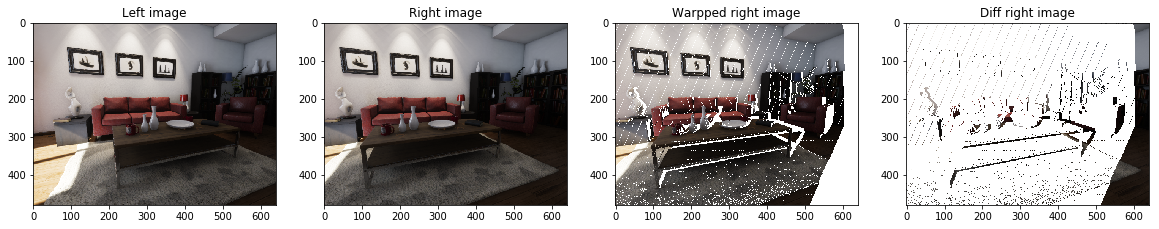

In [16]:
pose = np.array(get_pose())/180*np.pi
rot = Rotation.from_euler('xyz', pose).as_matrix()

# 
right_cam = np.array([[1, 0, 0]])
R_local_to_world = np.array([[0, 0, 1], [1, 0, 0], [0, -1, 0]])
right_world = ((R_local_to_world @ rot @right_cam.T).T)[0]

loc = np.array(get_loc())

img_l = get_img()
depth = get_depth() * 100
plane_depth = DepthConversion(depth, fov=90)
baseline = 40
fov = 90
H, W = depth.shape
f = W /2 / np.tan(fov/180*np.pi/2)

disparity = f*baseline / plane_depth

# move camera to the right and record right image
new_loc = loc + baseline * right_world
set_loc(new_loc)
img_r = get_img()

# warp left image to right camera using disparity
img_r_warp = warp(img_l, disparity)

fig, axes = plt.subplots(1, 4, figsize=(20,20/4))
axes[0].imshow(img_l)
axes[0].set_title('Left image')
axes[1].imshow(img_r)
axes[1].set_title('Right image')
axes[2].imshow(img_r_warp)
axes[2].set_title('Warpped right image')
axes[3].imshow(abs(img_r.astype(int)-img_r_warp.astype(int)).astype("uint8"))
axes[3].set_title('Diff right image')

# Visualize Reprojected Point Cloud

In [17]:
coord = reproj(plane_depth, fov=90)

In [18]:
points = coord.reshape(-1, 3)

In [19]:
pc = dict(x=points[::10, 0], y=points[::10, 1], z=points[::10, 2])

In [20]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(pc)
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

## Plugin Commands

In [20]:
res = client.request('vget /unrealcv/status')
print(res)

Is Listening
Client Connected
9000
Configuration
Config file: D:/pull_request_merge/UE4RealisticRendering/Plugins/unrealcv/Binaries/RealisticRendering/WindowsNoEditor/RealisticRendering/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false



In [21]:
res = client.request('vget /unrealcv/version')
print(res)

0.3.10


In [22]:
client.disconnect()

In [22]:
binary.close()

Kill windows binary with command ['taskkill', '/F', '/IM', 'RealisticRendering.exe']
